<a href="https://colab.research.google.com/github/gastonbujia/curso-visualizacion-datos-SAN-2022/blob/main/notebooks/behavior/notebook_CalMS21_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>
CalMS21: Caltech Mouse Social Interaction Dataset 2021 🐁🐀
</h1>

Esta notebook es una adaptación de la provista por NeuroMatch Academy durante la escuela de [Computational Neuroscience](https://compneuro.neuromatch.io/tutorials/intro.html) curada por Ann Kenedy, que a su vez es una adapatación de la que fuera creada por Dipam Chakraborty en AIcrowd para el <a href=https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications>Multi-Agent Behavior Challenge</a>. La notebook original puede ser encontrada en este [link](https://compneuro.neuromatch.io/projects/behavior/README.html).

Este [dataset](https://data.caltech.edu/records/s0vdx-0k302) tiene estimaciones de pose-tracking de ratones interactuando socialmente.


# Import necessary modules and packages 📚


In [168]:
import os
import json
import numpy as np
import pandas as pd

In [ ]:
# instalar umap
!pip install umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=f9a893b623c190cc24aceb00dce61f8693951d2a485db5cb74ca7ffee5351e28
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


# Download the dataset 📲

The CalMS21 dataset is hosted by Caltech at https://data.caltech.edu/records/1991. For now, we'll focus on the Task 1 data, which can be downloaded as follows:

In [ ]:
# @title Download and unzip the data
import os, requests, zipfile

fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

The dataset files are stored as json files. For ease of handling, we'll first convert them to .npy files using the script we just downloaded, `calms21_convert_to_npy.py`. The output of this script is a pair of files, `calms21_task1_train.npy` and `calms21_task1_test.npy`.

If you include the optional `parse_treba` flag, the script will create files `calms21_task1_train_features.npy` and `calms21_task1_test_features.npy`, which contain 32 features created using <a href=https://openaccess.thecvf.com/content/CVPR2021/html/Sun_Task_Programming_Learning_Data_Efficient_Behavior_Representations_CVPR_2021_paper.html>Task Programming</a>.



In [ ]:
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.' --parse_treba

tcmalloc: large alloc 1224941568 bytes == 0x333e000 @  0x7f1f27caa1e7 0x4b2150 0x5ac2ec 0x5dc6af 0x58ee9b 0x5901a3 0x5e3f6b 0x58ee7f 0x5901a3 0x59045e 0x59073e 0x5f3a00 0x4d18aa 0x51b31c 0x5b4a3e 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x51740e 0x5b41c5 0x604133 0x606e06 0x606ecc 0x609aa6 0x64d332 0x64d4de 0x7f1f278a7c87 0x5b561a
tcmalloc: large alloc 1224941568 bytes == 0x4c370000 @  0x7f1f27caa1e7 0x4b2150 0x52fcd2 0x52cdd3 0x545a88 0x58ea5d 0x51b4e6 0x5b41c5 0x4ba899 0x4d29f9 0x590d5e 0x591334 0x507cf4 0x5f3a2b 0x4d18aa 0x51b31c 0x5b4a3e 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x51740e 0x5b41c5 0x604133 0x606e06 0x606ecc 0x609aa6 0x64d332 0x64d4de
Saving ./calms21_task1_train
Saving ./calms21_task1_test
tcmalloc: large alloc 1224941568 bytes == 0x2c80000 @  0x7efdeedeb1e7 0x4b2150 0x5ac2ec 0x5dc6af 0x58ee9b 0x5901a3 0x5e3f6b 0x58ee7f 0x5901a3 0x59045e 0x59073e 0x5f3a00 0x4d18aa 0x51b31c 0x5b4a3e 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x5174

# Cargamos la data 💾
The following loader function can be used to unpack the `.npy` files containing your train and test sets.

In [ ]:
def load_task1_data(data_path, features_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  features = np.load(features_path, allow_pickle=True).item()['annotator-id_0']
  return dataset, features, vocabulary

In [ ]:
training_data, training_features, vocab = load_task1_data('./calms21_task1_train.npy', './calms21_task1_train_features.npy')

## Dataset Specifications

`training_data` and `test_data` are both dictionaries with a key for each Sequence in the dataset, where a Sequence is a single resident-intruder assay. Each Sequence contains the following fields:

<ul>
<li><b>keypoints</b>: tracked locations of body parts on the two interacting mice. These are produced using a Stacked Hourglass network trained on 15,000 hand-labeled frames.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (x, y coordinate) x (body part).
<li>Units: pixels; coordinates are relative to the entire image. Original image dimensions are 1024 x 570.
</ul>
<li><b>scores</b>: confidence estimates for the tracked keypoints.
<ul>
<li>Dimensions: (# frames) x (mouse ID) x (body part).
<li>Units: unitless, range 0 (lowest confidence) to 1 (highest confidence).
</ul>
<li> <b>annotations</b>: behaviors id as an integer annotated at each frame by a domain expert. See below for the behavior id to behavior name mappings.
<ul>
<li>Dimensions: (# frames) .
</ul>
<li><b>metadata</b>: The recorded metadata is annotator_id which is represented by an int, and the vocab, containing a dictionary which maps behavior names to integer ids in annotations.
</ul>

The 'taskprog_features' file contains the additional field:

<ul>
<li><b>features</b>: pre-computed features from a model trained with task programming on the trajectory data of the CalMS21 unlabeled videos set.
<ul>
<li>Dimensions: (# frames) x (feature dim = 32).
</li>
</ul>
</ul>

<b>NOTE:</b> for all keypoints, mouse 0 is the resident (black) mouse and mouse 1 is the intruder (white) mouse. There are 7 tracked body parts, ordered (nose, left ear, right ear, neck, left hip, right hip, tail base).

## What does the data look like? 🔍

### Data overview

As described above, our dataset consists of train and test sets, which are both dictionaries of Sequences, and an accompanying vocabulary telling us which behavior is which:

In [ ]:
print("Sample dataset keys: ", list(training_data.keys())[:3])
print("Vocabulary: ", vocab)
print("Number of train Sequences: ", len(training_data))

Sample dataset keys:  ['task1/train/mouse001_task1_annotator1', 'task1/train/mouse002_task1_annotator1', 'task1/train/mouse003_task1_annotator1']
Vocabulary:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}
Number of train Sequences:  70


### Sample overview
Next let's take a look at one example Sequence:

In [ ]:
type(training_data['task1/train/mouse001_task1_annotator1'])

dict

In [ ]:
sequence_names = list(training_data.keys())
sample_sequence_key = sequence_names[0]
single_sequence = training_data[sample_sequence_key]
print("Name of our sample sequence: ", sample_sequence_key)
print("Sequence keys: ", single_sequence.keys())
print("Sequence metadata: ", single_sequence['metadata'])
print(f"Number of Frames in Sequence \"{sample_sequence_key}\": ", len(single_sequence['annotations']))
print(f"Keypoints data shape of Sequence \"{sample_sequence_key}\": ", single_sequence['keypoints'].shape)

Name of our sample sequence:  task1/train/mouse001_task1_annotator1
Sequence keys:  dict_keys(['keypoints', 'scores', 'annotations', 'metadata'])
Sequence metadata:  {'annotator-id': 0, 'vocab': {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}}
Number of Frames in Sequence "task1/train/mouse001_task1_annotator1":  21364
Keypoints data shape of Sequence "task1/train/mouse001_task1_annotator1":  (21364, 2, 2, 7)


In [ ]:
pd.DataFrame(training_data).head()

,task1/train/mouse001_task1_annotator1,task1/train/mouse002_task1_annotator1,task1/train/mouse003_task1_annotator1,task1/train/mouse004_task1_annotator1,task1/train/mouse005_task1_annotator1,task1/train/mouse006_task1_annotator1,task1/train/mouse007_task1_annotator1,task1/train/mouse008_task1_annotator1,task1/train/mouse009_task1_annotator1,task1/train/mouse010_task1_annotator1,...,task1/train/mouse061_task1_annotator1,task1/train/mouse062_task1_annotator1,task1/train/mouse063_task1_annotator1,task1/train/mouse064_task1_annotator1,task1/train/mouse065_task1_annotator1,task1/train/mouse066_task1_annotator1,task1/train/mouse067_task1_annotator1,task1/train/mouse068_task1_annotator1,task1/train/mouse069_task1_annotator1,task1/train/mouse070_task1_annotator1
keypoints,[[[[831.6592041 805.6592041 775.6592041 780.65...,[[[[214.97402802 183.97402802 139.97402802 148...,[[[[397.97654724 444.97654724 439.97654724 455...,[[[[840.89483643 823.89483643 883.89483643 857...,[[[[608.14988403 557.14988403 561.14988403 540...,[[[[725.06564941 748.06564941 774.06564941 778...,[[[[148.43171387 113.43171387 169.43171387 142...,[[[[461.98978271 408.98978271 464.98978271 432...,[[[[709.38247681 726.38247681 765.38247681 753...,[[[[327.62959595 373.62959595 401.62959595 400...,...,[[[[774.77977905 741.77977905 804.77977905 765...,[[[[366.9783783 303.9783783 346.9783783 313.97...,[[[[858.93834839 807.93834839 795.93834839 789...,[[[[739.05790405 729.05790405 788.05790405 765...,[[[[738.07294922 685.07294922 696.07294922 673...,[[[[269.20490417 225.20490417 224.20490417 212...,[[[[313.98577728 276.98577728 248.98577728 247...,[[[[185.59334564 171.59334564 121.59334564 138...,[[[[607.65760498 643.65760498 663.65760498 653...,[[[[785.31534424 794.31534424 841.31534424 824...
scores,"[[[0.49552804231643677, 0.66752028465271, 0.72...","[[[0.7875715494155884, 0.7696621417999268, 0.8...","[[[0.480934739112854, 0.6976069808006287, 0.48...","[[[0.6032909750938416, 0.4844147562980652, 0.5...","[[[0.39745843410491943, 0.5035790205001831, 0....","[[[0.5327984690666199, 0.4053669571876526, 0.4...","[[[0.49128609895706177, 0.568804919719696, 0.5...","[[[0.45199355483055115, 0.6156253814697266, 0....","[[[0.23436476290225983, 0.12976549565792084, 0...","[[[0.5448248982429504, 0.4935837984085083, 0.5...",...,"[[[0.6645034551620483, 0.5499401092529297, 0.5...","[[[0.6821759939193726, 0.704423725605011, 0.70...","[[[0.4013247489929199, 0.5359834432601929, 0.6...","[[[0.6679304838180542, 0.6781067252159119, 0.6...","[[[0.5025370121002197, 0.7341359853744507, 0.5...","[[[0.37778836488723755, 0.5549989938735962, 0....","[[[0.6915003061294556, 0.6259832382202148, 0.6...","[[[0.7152268290519714, 0.4989011287689209, 0.6...","[[[0.5967026352882385, 0.4186252951622009, 0.3...","[[[0.45764708518981934, 0.1680891215801239, 0...."
annotations,"[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,"[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
metadata,"{'annotator-id': 0, 'vocab': {'attack': 0, 'in...","{'annotator-id': 0, 'vocab': {'attack': 0, 'in...","

#Nos vamos para Pandas! 🐼

In [ ]:
# Ejercicio 1
def load_annotator_df(data_dict, annotator):
    
    dict_aux = data_dict[annotator]
    annot_keys = {0:'attack',1: 'investigation',2: 'mount',3:'other'}
    body_parts = ["nose", "left_ear", "right_ear", "neck", "left_hip", "right_hip", "tail_base"]
    df_list = []
    
    # desagregamos los keypoints en columnas para cada parte trackeada
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,0,0,:] , dtype=float, columns=['keypoints_mousse_resident_x_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,0,1,:] , dtype=float, columns=['keypoints_mousse_resident_y_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,1,0,:] , dtype=float, columns=['keypoints_mousse_intruder_x_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['keypoints'][:,1,1,:] , dtype=float, columns=['keypoints_mousse_intruder_y_'+i for i in body_parts]))
    
    # desagregamos la confianza de los keypoints 
    df_list.append(pd.DataFrame(dict_aux['scores'][:,0,:] , dtype=float, columns=['keypoints_mousse_resident_confidence_'+i for i in body_parts]))
    df_list.append(pd.DataFrame(dict_aux['scores'][:,1,:] , dtype=float, columns=['keypoints_mousse_intruder_confidence_'+i for i in body_parts]))

    # COMPLETAR: crear un único dataframe que sea el resultado de concatenar todos los dataframes de la lista df_list que contenga todas las columnas
    df = pd.concat(df_list,axis=1)

    # COMPLETAR: agregar al dataframe recien creado una columna con la etiqueta correspondiente
    df['annotations'] = dict_aux['annotations']

    # COMPLETAR: reemplazar la columna annotations por una que codifique el comportamiento anotado
    df['annotations'] = df['annotations'].map(annot_keys)
    
    return df
  
df = load_annotator_df(training_data, 'task1/train/mouse066_task1_annotator1')
df.head()

,keypoints_mousse_resident_x_nose,keypoints_mousse_resident_x_left_ear,keypoints_mousse_resident_x_right_ear,keypoints_mousse_resident_x_neck,keypoints_mousse_resident_x_left_hip,keypoints_mousse_resident_x_right_hip,keypoints_mousse_resident_x_tail_base,keypoints_mousse_resident_y_nose,keypoints_mousse_resident_y_left_ear,keypoints_mousse_resident_y_right_ear,...,keypoints_mousse_resident_confidence_right_hip,keypoints_mousse_resident_confidence_tail_base,keypoints_mousse_intruder_confidence_nose,keypoints_mousse_intruder_confidence_left_ear,keypoints_mousse_intruder_confidence_right_ear,keypoints_mousse_intruder_confidence_neck,keypoints_mousse_intruder_confidence_left_hip,keypoints_mousse_intruder_confidence_right_hip,keypoints_mousse_intruder_confidence_tail_base,annotations
0,269.204904,225.204904,224.204904,212.204904,175.204904,141.204904,132.204904,177.763262,208.763262,148.763262,...,0.627449,0.799457,0.343508,0.576258,0.407013,0.711372,0.722617,0.770358,0.764414,other
1,274.551988,233.551988,226.551988,216.551988,180.551988,148.551988,129.551988,186.789761,213.789761,156.789761,...,0.721785,0.760385,0.488087,0.524018,0.470854,0.789173,0.553372,0.663938,0.621979,other
2,291.186159,236.186159,227.186159,218.186159,185.186159,153.186159,131.186159,180.416301,202.416301,156.416301,...,0.678676,0.823244,0.169889,0.412065,0.299222,0.620719,0.325731,0.561589,0.568488,investigation
3,277.111665,245.111665,226.111665,226.111665,189.111665,148.111665,129.111665,171.551022,202.551022,157.551022,...,0.521509,0.871232,0.322495,0.463870,0.463585,0.693445,0.636854,0.768979,0.838159,investigation
4,280.601614,243.601614,223.601614,220.601614,191.601614,142.601614,128.601614,162.003889,199.003889,152.003889,...,0.585775,0.841161,0.635784,0.564176,0.687042,0.805842,0.692411,0.688804,0.628524,investigation


In [ ]:
df.annotations.unique()

array(['other', 'investigation', 'mount'], dtype=object)

Descartamos un total de 4890 frames


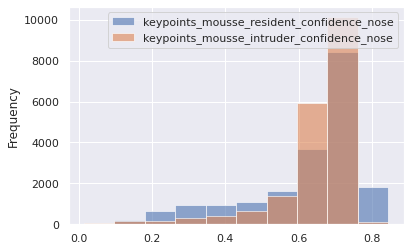

In [ ]:
# COMPLETAR: Graficar la distribución de la confianza de los keypoints estimate para la nariz de cada raton
df[["keypoints_mousse_resident_confidence_nose", "keypoints_mousse_intruder_confidence_nose"]].plot(kind='hist',alpha=0.6);

# En base a lo anterior vamos a decidir un umbral para el cual la confianza es mayor a ese valor y quedarnos
# solo con los frames donde la estimación sea confiable para ambos puntos
cols = ["keypoints_mousse_resident_confidence_nose", "keypoints_mousse_intruder_confidence_nose"]
thres = 0.5
df_filter = df[(df[cols]>thres).all(axis=1)]

# PREGUNTA: Cuantos datos tiraron?
total_tirados = df.shape[0]-df_filter.shape[0]
print(f'Descartamos un total de {total_tirados} frames')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

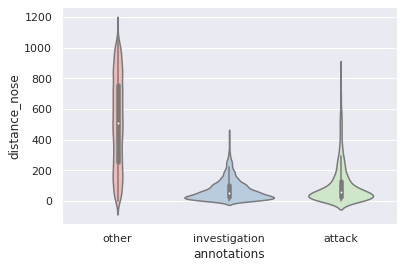

In [ ]:
# COMPLETAR: Crear una nueva columna que mida la distancia entre las narices de los ratones
df['distance_nose'] = np.sqrt((df["keypoints_mousse_resident_x_nose"] - df["keypoints_mousse_intruder_x_nose"])**2 + (df["keypoints_mousse_resident_x_nose"] - df["keypoints_mousse_intruder_x_nose"])**2)

# COMPLETAR: Graficar para cada comportamiento registrado la distribución de estas distancias (usar un violinplot)
sns.violinplot(x="annotations", y="distance_nose", data=df, palette="Pastel1")
plt.show()

In [ ]:
# Veamos que pasa cuando observamos las features de los frames si nos permiten separar los comportamientos
def load_annotator_features(feat_dict, annotator):
    
    dict_aux = feat_dict[annotator]
    annot_keys = {0:'attack',1: 'investigation',2: 'mount',3:'other'}
    
    df = pd.DataFrame(dict_aux['features'] , dtype=float)
    df['annotations'] = dict_aux['annotations']
    df['annotations'] = df['annotations'].map(annot_keys)
    
    return df
  
df_features = load_annotator_features(training_features, 'task1/train/mouse001_task1_annotator1')
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,annotations
0,831.659204,805.659204,775.659204,780.659204,711.659204,711.659204,643.659204,202.914433,250.914433,189.914433,...,-1.686340,-0.170703,0.215731,0.251000,0.227394,0.221438,-0.341884,-0.258297,0.247844,other
1,833.050439,809.050439,778.050439,783.050439,723.050439,717.050439,644.050439,201.895063,251.895063,193.895063,...,-1.253083,-0.135972,0.246578,0.284343,0.260936,0.256414,-0.275257,-0.288740,0.288741,investigation
2,838.718976,816.718976,776.718976,787.718976,730.718976,713.718976,646.718976,179.862692,244.862692,193.862692,...,-0.375269,-0.001808,0.268099,0.302942,0.285639,0.274443,-0.085661,-0.299937,0.309663,investigation
3,826.757507,815.757507,774.757507,785.757507,743.757507,711.757507,644.757507,175.148063,235.148063,187.148063,...,0.709808,-0.099615,0.260069,0.291605,0.270890,0.252054,0.117812,-0.249731,0.304101,investigation
4,822.045709,812.045709,768.045709,779.045709,749.045709,709.045709,646.045709,174.457936,222.457936,178.457936,...,1.831389,-0.167013,0.261911,0.262023,0.235552,0.209837,0.161930,-0.224229,0.255363,investigation


In [ ]:
# COMPLETAR: seleccionar las columnas correspondientes a los features y guardarla en una variable X
X = df_features.iloc[:,:60].to_numpy()
print(X.shape)

(21364, 60)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# UMAP
import umap
#import umap.plot

In [ ]:
# Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Instanciar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert to data frame
principal_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
principal_df['annotations'] = df_features['annotations']
# Shape and preview
print(principal_df.shape)
principal_df.head()

(21364, 3)


,PC1,PC2,annotations
0,-4.592838,-4.813086,other
1,-5.326409,-4.796462,investigation
2,-5.742800,-4.799456,investigation
3,-5.297018,-4.750459,investigation
4,-4.620037,-4.727178,investigation


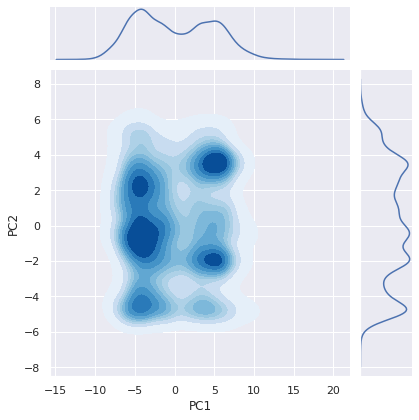

In [ ]:
# Grafiquemos que sucede con la distribución espacial de las features
sns.jointplot(x=principal_df.PC1, y=principal_df.PC2, cmap="Blues", shade=True, kind='kde');

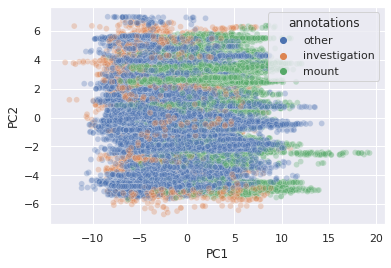

In [ ]:
# COMPLETAR
sns.scatterplot( x="PC1", y="PC2", data=principal_df, hue='annotations', legend=True, alpha=0.3);

In [170]:
import plotly.express as px

# PCA
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)

principal_df = pd.DataFrame(data = components, columns = ['PC1', 'PC2', 'PC3'])
principal_df['annotations'] = df_features['annotations']

# 3D scatterplot
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=principal_df['annotations'], size=0.1*np.ones(len(X)), opacity = 1,
    title='PCA plot in 3D',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=650, height=500
)
fig.show()

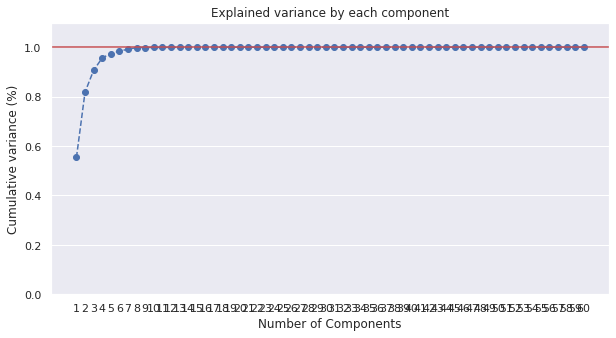

In [ ]:
# Si queremos podemos ver la varianza explicada
pca_var = PCA()
pca_var.fit(X)

# Plot
plt.figure(figsize=(10,5))
xi = np.arange(1, 1+X_scaled.shape[1], step=1)
yi = np.cumsum(pca_var.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.gca().xaxis.grid(False)

In [ ]:
# Probemos que sucede si usamos tsne
# t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to data frame
tsne_df = pd.DataFrame(data = X_tsne, columns = ['tsne comp. 1', 'tsne comp. 2'])

# Shape and preview
print(tsne_df.shape)
tsne_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(21364, 2)


,tsne comp. 1,tsne comp. 2
0,-34.154083,-26.384312
1,-34.082283,-26.412306
2,-33.956181,-26.505768
3,-33.676613,-26.782959
4,-33.294765,-27.192123


Text(0, 0.5, 'tsne component 2')

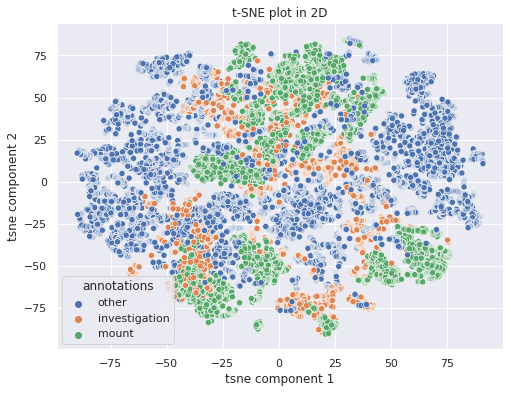

In [ ]:
# Figure size
plt.figure(figsize=(8,6))

# Scatterplot
sns.scatterplot(x=tsne_df.iloc[:,0], y=tsne_df.iloc[:,1], hue=principal_df['annotations'])

# Aesthetics
plt.title('t-SNE plot in 2D')
plt.xlabel('tsne component 1')
plt.ylabel('tsne component 2')

In [ ]:
# Probemos UMAP

In [ ]:
training_data['task1/train/mouse001_task1_annotator1']['scores']

array([[[0.49552804, 0.66752028, 0.72330576, ..., 0.66447091,
         0.77898151, 0.92227948],
        [0.69960815, 0.75106651, 0.79522413, ..., 0.71904349,
         0.68235272, 0.93287802]],

       [[0.52485162, 0.66523784, 0.73530108, ..., 0.6501978 ,
         0.79137212, 0.92976916],
        [0.68289757, 0.73821032, 0.78257012, ..., 0.72285211,
         0.65472221, 0.93213403]],

       [[0.48510984, 0.61267781, 0.69941068, ..., 0.61482728,
         0.7053569 , 0.91542822],
        [0.68183005, 0.69482088, 0.76917887, ..., 0.74480313,
         0.61418235, 0.92933071]],

       ...,

       [[0.55609357, 0.73330641, 0.7904743 , ..., 0.90438694,
         0.75335521, 0.91634762],
        [0.70011842, 0.60760337, 0.44464201, ..., 0.7054196 ,
         0.68583381, 0.49405858]],

       [[0.56423283, 0.73055446, 0.80087376, ..., 0.89755309,
         0.74307597, 0.91033357],
        [0.71542048, 0.63457692, 0.38595554, ..., 0.69721591,
         0.67789042, 0.47399443]],

       [[0.552242

Preguntas que se me ocurren que se les puede pedir:

- Completar la funcion de ayuda para separar los datos cargados de forma que cada 
- Cuando los ratones fueron etiquetados con determinada etiqueta, que tan cerca estabn sus narices, histograma, etc
- Hacer el raster
- Incluir algo de correlaciones y test estadisticos?
- En un solo grafico poner todos los anotadores?
- ~~Usar la confianza~~

# Helper functions for visualization 💁


This cell contains some helper functions that we'll use to create an animation of the mouse movements. You can ignore the contents, but be sure to run it or the next section won't work.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches

rc('animation', html='jshtml')

# Note: Image processing may be slow if too many frames are animated.

# Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570

RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'

PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
class_to_color = {'other': 'white', 'attack' : 'red', 'mount' : 'green',
                  'investigation': 'orange'}
class_to_number = {s: i for i, s in enumerate(vocab)}
number_to_class = {i: s for i, s in enumerate(vocab)}


def num_to_text(anno_list):
  return np.vectorize(number_to_class.get)(anno_list)


def set_figax():
  fig = plt.figure(figsize=(6, 4))

  img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

  ax = fig.add_subplot(111)
  ax.imshow(img)

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  return fig, ax


def plot_mouse(ax, pose, color):
  # Draw each keypoint
  for j in range(7):
    ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)

  # Draw a line for each point pair to form the shape of the mouse

  for pair in PLOT_MOUSE_START_END:
    line_to_plot = pose[pair, :]
    ax.plot(line_to_plot[:, 0], line_to_plot[
            :, 1], color=color, linewidth=1)


def animate_pose_sequence(video_name, keypoint_sequence, start_frame = 0, stop_frame = 100,
                          annotation_sequence = None):
  # Returns the animation of the keypoint sequence between start frame
  # and stop frame. Optionally can display annotations.
  seq = keypoint_sequence.transpose((0,1,3,2))

  image_list = []

  counter = 0
  for j in range(start_frame, stop_frame):
    if counter%20 == 0:
      print("Processing frame ", j)
    fig, ax = set_figax()
    plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
    plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)

    if annotation_sequence is not None:
      annot = annotation_sequence[j]
      annot = number_to_class[annot]
      plt.text(50, -20, annot, fontsize=16,
               bbox=dict(facecolor=class_to_color[annot], alpha=0.5))

    ax.set_title(
        video_name + '\n frame {:03d}.png'.format(j))

    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                    dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))

    image_list.append(image_from_plot)

    plt.close()
    counter = counter + 1

  # Plot animation.
  fig = plt.figure()
  plt.axis('off')
  im = plt.imshow(image_list[0])

  def animate(k):
      im.set_array(image_list[k])
      return im,
  ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
  return ani


def plot_behavior_raster(annotation_sequence, start_frame=0,
                         stop_frame=100,
                         title="Behavior Labels"):
  # Plot annotations as a behavior raster

  # Map annotations to a number.
  annotation_num = []
  for item in annotation_sequence[start_frame:stop_frame]:
    annotation_num.append(class_to_number[item])

  all_classes = list(set(annotation_sequence[start_frame:stop_frame]))

  cmap = colors.ListedColormap(['red', 'orange', 'green', 'white'])
  bounds=[-0.5, 0.5, 1.5, 2.5, 3.5]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  height = 200
  arr_to_plot = np.repeat(np.array(annotation_num)[:, np.newaxis].transpose(),
                                                  height, axis = 0)

  fig, ax = plt.subplots(figsize = (16, 3))
  ax.imshow(arr_to_plot, interpolation='none',cmap=cmap, norm=norm)

  ax.set_yticks([])
  ax.set_xlabel('Frame Number')
  plt.title(title)

  legend_patches = []
  for item in all_classes:
    legend_patches.append(mpatches.Patch(color=class_to_color[item], label=item))

  plt.legend(handles=legend_patches,loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()

# Visualize the animals' movements 🎥

Let's make some gifs of our sample sequence to get a sense of what the raw data looks like! You can change the values of `start_frame` and `stop_frame` to look around.

Processing frame  5000
Processing frame  5020
Processing frame  5040
Processing frame  5060
Processing frame  5080


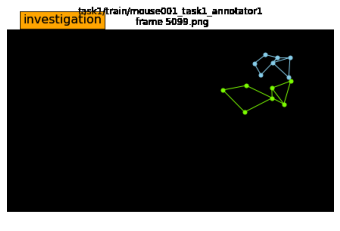

In [ ]:
keypoint_sequence = single_sequence['keypoints']
annotation_sequence = single_sequence['annotations']

ani = animate_pose_sequence(sample_sequence_key,
                            keypoint_sequence,
                            start_frame=5000,
                            stop_frame=5100,
                            annotation_sequence=annotation_sequence)

# Display the animaion on colab
ani

### We can also look at a **behavior raster**, which shows what behavior was annotated on each frame of this video.

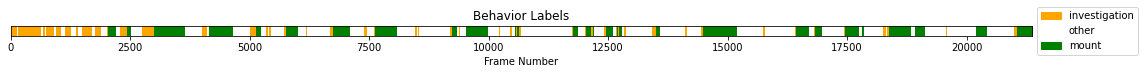

In [ ]:
annotation_sequence = single_sequence['annotations']
text_sequence = num_to_text(annotation_sequence)

plot_behavior_raster(
    text_sequence,
    start_frame=0,
    stop_frame=len(annotation_sequence)
    )

# Basic exploratory data analysis 🤓
Each Sequence has different amounts of each behavior, depending on what the mice do during the assay. Here, we get the percentage of frames of each behavior in each sequence. We can use this to split the training set into train and validation sets in a stratified way.

In [ ]:
def get_percentage(sequence_key):
  anno_seq = num_to_text(training_data[sequence_key]['annotations'])
  counts = {k: np.mean(np.array(anno_seq) == k)*100.0 for k in vocab}
  return counts


anno_percentages = {k: get_percentage(k) for k in training_data}
anno_perc_df = pd.DataFrame(anno_percentages).T
print("Percentage of frames in every sequence for every class")
anno_perc_df.head()

Percentage of frames in every sequence for every class


,attack,investigation,mount,other
task1/train/mouse001_task1_annotator1,0.000000,15.788242,30.251826,53.959933
task1/train/mouse002_task1_annotator1,9.067880,22.757587,0.000000,68.174533
task1/train/mouse003_task1_annotator1,0.000000,13.757374,13.167448,73.075178
task1/train/mouse004_task1_annotator1,0.000000,16.440199,7.735773,75.824028
task1/train/mouse005_task1_annotator1,7.516398,13.614607,0.000000,78.868995


## Percent of frames of each behavior in the full training set
Having looked at behavior distributions in a couple example Sequences, let's now look at the average over the entire training set.

In [ ]:
all_annotations = []
for sk in training_data:
  anno = training_data[sk]['annotations']
  all_annotations.extend(list(anno))

all_annotations = num_to_text(all_annotations)
classes, counts = np.unique(all_annotations, return_counts=True)
pd.DataFrame({"Behavior": classes,
              "Percentage Frames": counts/len(all_annotations)*100.0})

,Behavior,Percentage Frames
0,attack,2.765009
1,investigation,28.876113
2,mount,5.635781
3,other,62.723097


# Split training data into train/validation sets
Because we don't want to overfit to our test set, we'll create a new validation set to test on while we're experimenting with our model.

We'll use the first cell to create some helper functions, and then implement the split in the following cell.

In [ ]:
from sklearn.model_selection import train_test_split


def num_to_text(number_to_class, anno_list):
  """
  Convert list of class numbers to list of class names
  """
  return np.vectorize(number_to_class.get)(anno_list)


def split_validation(orig_pose_dictionary, vocabulary, seed=2021,
               test_size=0.5, split_videos=False):
  """
  Split data into train and validation sets:
  * Full sequences are either put into train or validation to avoid data leakage
  * By default, the "attack" behavior's presence is used to stratify the split
  * Optionally, the sequences may be split into half and treated as separate sequences
  """

  if test_size == 0.0:
    return orig_pose_dictionary, None

  number_to_class = {v: k for k, v in vocabulary.items()}
  if split_videos:
    pose_dictionary = {}
    for key in orig_pose_dictionary:
      key_pt1 = key + '_part1'
      key_pt2 = key + '_part2'
      anno_len = len(orig_pose_dictionary[key]['annotations'])
      split_idx = anno_len // 2
      pose_dictionary[key_pt1] = {
          'annotations': orig_pose_dictionary[key]['annotations'][:split_idx],
          'keypoints': orig_pose_dictionary[key]['keypoints'][:split_idx]}
      pose_dictionary[key_pt2] = {
          'annotations': orig_pose_dictionary[key]['annotations'][split_idx:],
          'keypoints': orig_pose_dictionary[key]['keypoints'][split_idx:]}
  else:
    pose_dictionary = orig_pose_dictionary

  def get_percentage(sequence_key):
    anno_seq = num_to_text(
        number_to_class, pose_dictionary[sequence_key]['annotations'])
    counts = {k: np.mean(np.array(anno_seq) == k) for k in vocabulary}
    return counts

  anno_percentages = {k: get_percentage(k) for k in pose_dictionary}

  anno_perc_df = pd.DataFrame(anno_percentages).T

  rng_state = np.random.RandomState(seed)
  try:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                          stratify=anno_perc_df['attack'] > 0,
                                          test_size=test_size,
                                          random_state=rng_state)
  except:
    idx_train, idx_val = train_test_split(anno_perc_df.index,
                                          test_size=test_size,
                                          random_state=rng_state)

  train_data = {k: pose_dictionary[k] for k in idx_train}
  val_data = {k: pose_dictionary[k] for k in idx_val}
  return train_data, val_data

In [ ]:
train, val = split_validation(training_data, vocab, test_size=0.25)
print("Number of Sequences in train set: ", len(train))
print("Number of Sequences in validation set: ", len(val))

Number of Sequences in train set:  52
Number of Sequences in validation set:  18


# Preprocessing script

We might also want to normalize the data, based on the information that the frame size is 1024x570

The original data is of shape (sequence length, mouse, x y coordinate, keypoint)
 = (length, 2, 2, 7)

If `rotate==True`, this code also swaps the x y and the keypoint axis, to make rotation of the poses (eg to center on one of the mice) easier.

In [ ]:
def normalize_data(orig_pose_dictionary, rotate=False):
  for key in orig_pose_dictionary:
    X = orig_pose_dictionary[key]['keypoints']
    if rotate:
      X = X.transpose((0, 1, 3, 2))  # last axis is x, y coordinates
      X[..., 0] = X[..., 0]/1024
      X[..., 1] = X[..., 1]/570
    else:
      X[:, :, 0, :] = X[:, :, 0, :] / 1024
      X[: ,:, 1, :] = X[:, :, 1, :] / 570
    orig_pose_dictionary[key]['keypoints'] = X
  return orig_pose_dictionary